# Final Experiments - Single-label CNNText Problem Statement

## Utilities and Imports

In [1]:
%reload_ext autoreload
%autoreload 2

import itertools
from collections import Counter
import numpy as np
import pickle
from operator import itemgetter
import matplotlib
from matplotlib import pyplot as plt

%matplotlib inline
# matplotlib.rcParams['figure.figsize'] = [5, 10]

from sklearn.model_selection import KFold, StratifiedKFold
from sklearn.pipeline import Pipeline
from sklearn.feature_extraction.text import CountVectorizer, TfidfVectorizer
from sklearn.metrics import classification_report, accuracy_score, confusion_matrix, f1_score
from sklearn.svm import LinearSVC, SVC
from nltk.corpus import stopwords
stop_words = stopwords.words('english')

import torch
import torch.nn as nn
import torch.nn.functional as F
from torch.autograd import Variable

from fastai import text as ft
from fastai import dataloader as fd
from fastai import dataset as fs
from fastai import learner as fl
from fastai import core as fc
from fastai import metrics as fm


from skai.runner import TextRunner, Adam_lambda
from skai.mwrapper import MWrapper, SKModel
from skai.utils import multi_to_text_out, vote_pred
from skai.utils import get_classification_type, weights_init, multilabel_prediction
from skai.dataset import TokenDataset, SimpleDataset


def mapt(f, *iters):
    return tuple(map(f, *iters))

def mapl(f, *iters):
    return list(map(f, *iters))

def manually_remove_problems(data):
    """ remove problem from data if it has a certain tag"""
    final_data = {}
    remove = ['*special']
    for i in data:
        if set(data[i][1][0]).intersection(set(remove)) == set():
            if data[i][0][0] != '':
                final_data[i] = data[i]
    return final_data

def get_single_label_problems(data):
    '''returns a dict of all problems which only have one label'''
    single_label_problems = {}
    for i in data:
        if len(data[i][1][0]) == 1:
            single_label_problems[i] = data[i]
    return single_label_problems

def get_classwise_distribution(data):
    class_count = {}
    for i in data:
        for cls in data[i][1][0]:
            if cls in class_count:
                class_count[cls] +=1 
            else:
                class_count[cls] = 1
    return class_count


def get_topk_single_label_problems(data,k):
    """ get top k by frequency single label problems"""
    class_dict = get_classwise_distribution(data)
    print(class_dict)
    class_dict = dict(sorted(class_dict.items(), key=itemgetter(1), reverse=True)[:k])
    print(set(class_dict.keys()))

    topk_data = {}
    for i in data:
        if set(data[i][1][0]).intersection(set(class_dict.keys())) != set():
            topk_data[i] = data[i]
            
    return topk_data

def make_text_dataset(rdata):
    Xtext, ytext = [], []
    for url, data in rdata.items():
        try:
            ytext.append(data[1][0][0])
        except IndexError:
            continue
        Xtext.append(data[0][0])
    return Xtext, ytext

def make_statement_dataset(rdata):
    Xtext, ytext = [], []
    for url, data in rdata.items():
        try:
            ytext.append(data[1][0][0])
        except IndexError:
            continue
        Xtext.append(data[0][2])
    return Xtext, ytext

def get_class_list(labels):
    return list(set(labels))

def plot_confusion_matrix(y_true, y_pred, classes,
                          normalize=True,
                          title='Confusion matrix',
                          cmap=plt.cm.Blues):
    """
    This function prints and plots the confusion matrix.
    Normalization can be applied by setting `normalize=True`.
    """
    cm = confusion_matrix(y_true, y_pred, labels=classes)
    if normalize:
        cm = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]
        print("Normalized confusion matrix")
    else:
        print('Confusion matrix, without normalization')

    print(cm)
    fig = plt.gcf()
    fig.set_size_inches(22, 16)
    plt.imshow(cm, interpolation='nearest', cmap=cmap, vmin=0.0, vmax=1.0)
#     plt.title(title, fontsize)
    plt.colorbar()
    tick_marks = np.arange(len(classes))
    plt.xticks(tick_marks, classes, fontsize=32)
    plt.yticks(tick_marks, classes, fontsize=32)

    print(cm.max())
    fmt = '.2f' if normalize else 'd'
    thresh = 0.5
    for i, j in itertools.product(range(cm.shape[0]), range(cm.shape[1])):
        plt.text(j, i, format(cm[i, j], fmt),
                 horizontalalignment="center",
                 color="white" if cm[i, j] > thresh else "black",
                 fontsize=32)

    plt.tight_layout()
    plt.ylabel('True label', fontsize=32)
    plt.xlabel('Predicted label', fontsize=32)

/home/aayn/anaconda3/envs/fastai/lib/python3.6/site-packages/sklearn/ensemble/weight_boosting.py:29: DeprecationWarning: numpy.core.umath_tests is an internal NumPy module and should not be imported. It will be removed in a future NumPy release.
  from numpy.core.umath_tests import inner1d


## Load data

In [2]:
top5s = pickle.load(open('data/110_5single_26aug.pkl','rb'))
top10s = pickle.load(open('data/10single_26aug.pkl','rb'))

top5ps, top10ps = mapt(make_statement_dataset, [top5s, top10s])

In [3]:
print(len(top10ps[0]))

1159


In [4]:
print(top10ps[0][0])


Eighth-grader Vova is on duty today in the class. After classes, he went into the office to wash the board, and found on it the number n. He asked what is this number and the teacher of mathematics Inna Petrovna answered Vova that n is the answer to the arithmetic task for first-graders. In the textbook, a certain positive integer x was given. The task was to add x to the sum of the digits of the number x written in decimal numeral system.
Since the number n on the board was small, Vova quickly guessed which x could be in the textbook. Now he wants to get a program which will search for arbitrary values of the number n for all suitable values of x or determine that such x does not exist. Write such a program for Vova.





## CNN Experiments

In [5]:
class CNN_Text(nn.Module):
    def __init__(self, embed_num, class_num, channel_in=1, 
                 kernel_sizes=[3, 4, 5], kernel_num=512, embed_dim=300):
        super().__init__()
        self.kernel_num = kernel_num
        self.embed = nn.Embedding(embed_num, embed_dim)
        
        convs = [nn.Conv1d(1, kernel_num, (ks, embed_dim))
                 for ks in kernel_sizes]
        self.convs = nn.ModuleList(convs)
#         self.bn1 = nn.BatchNorm2d(kernel_num)
        self.fc1 = nn.Linear(len(kernel_sizes) * kernel_num, class_num)
    
    def conv_and_pool(self, x, conv):
        x = F.relu(conv(x)).squeeze(3)  # (N, Co, W)
        x = F.max_pool1d(x, x.size(2)).squeeze(2)
        return x
    
    def forward(self, x):
        x = self.embed(x)
        x = x.unsqueeze(1)
        
        x = [F.relu(conv(x)).squeeze(3) for conv in self.convs]
        x = [F.max_pool1d(i, i.size(2)).squeeze(2) for i in x]
        x = torch.cat(x, 1)
        
        out = self.fc1(x)
        return out

### 5-class

In [6]:
trunner = TextRunner([None], top5ps[0], top5ps[1], 'top5ps')
in_dim = len(trunner.alldata.tvectorizer.itos)
Xall, yall = trunner.dataset

Checkpoint reached: raw data cleaned.
multiclass classification.


In [13]:
runs = 5
out_dim = 5

preds_txt, targs_txt = [], []

for i in range(runs):
    outer_cv = KFold(n_splits=10, shuffle=True, random_state=i)
    
    outer_cv.get_n_splits(Xall, yall)
    for j, (nontest_i, test_i) in enumerate(outer_cv.split(Xall, yall)):
        X_train, y_train = Xall[nontest_i], yall[nontest_i]
        X_test, y_test = Xall[test_i], yall[test_i]
        
        textcnn = MWrapper(CNN_Text(in_dim, out_dim),
                           f'{i}_cnntext5ps_{j}')
        textcnn.model.apply(weights_init)

        dl_train = fd.DataLoader(SimpleDataset(X_train, y_train),
                                 batch_size=32, num_workers=2,
                                 pad_idx=1, transpose=False)
        dl_val = fd.DataLoader(SimpleDataset(X_test, y_test),
                               batch_size=32, num_workers=2,
                               pad_idx=1, transpose=False)
        modeldata = fs.ModelData(str(textcnn.path), dl_train, dl_val)
        learner = fl.Learner.from_model_data(textcnn.model,
                                             modeldata,
                                             opt_fn=Adam_lambda())
        learner.metrics = [fm.accuracy]
        learner.fit(5e-4, 10, best_save_name='best')
        
        dl_test = fd.DataLoader(SimpleDataset(X_test, y_test),
                                batch_size=32, num_workers=2,
                                pad_idx=1, transpose=False)
        learner.load('best')
        preds, targs = learner.predict_dl(dl_test)
        preds_txt += multi_to_text_out(preds, trunner.alldata.ovectorizer)
        targs_txt += multi_to_text_out(targs, trunner.alldata.ovectorizer)
        print(accuracy_score(targs_txt, preds_txt))

Note: Model directory for 0_cnntext5ps_0 exists.


epoch      trn_loss   val_loss   accuracy                  
    0      0.167791   0.159787   0.181818  
    1      0.157221   0.155465   0.345455                  
    2      0.145874   0.151479   0.290909                  
    3      0.132389   0.147393   0.345455                  
    4      0.116666   0.144483   0.418182                  
    5      0.099099   0.143225   0.472727                  
    6      0.080624   0.141812   0.436364                   
    7      0.062663   0.140442   0.454545                   
    8      0.046965   0.142048   0.418182                   
    9      0.034473   0.143681   0.4                        

0.4727272727272727
Note: Model directory for 0_cnntext5ps_1 exists.


epoch      trn_loss   val_loss   accuracy                  
    0      0.166941   0.154562   0.327273  
    1      0.156672   0.149157   0.4                       
    2      0.146131   0.142559   0.418182                  
    3      0.133256   0.134113   0.527273                  
    4      0.11764    0.126676   0.545455                  
    5      0.099669   0.122298   0.563636                  
    6      0.080613   0.118176   0.563636                   
    7      0.062291   0.115797   0.563636                   
    8      0.046551   0.114374   0.581818                   
    9      0.034181   0.113731   0.6                        

0.5363636363636364


epoch      trn_loss   val_loss   accuracy                  
    0      0.169657   0.158198   0.345455  
    1      0.157615   0.156783   0.272727                  
    2      0.145905   0.151525   0.345455                  
    3      0.132166   0.144924   0.381818                  
    4      0.116168   0.139603   0.418182                  
    5      0.098286   0.137546   0.509091                  
    6      0.079439   0.137941   0.490909                   
    7      0.061281   0.138223   0.454545                   
    8      0.045706   0.138009   0.454545                   
    9      0.03352    0.138191   0.436364                   

0.5272727272727272


 50%|█████     | 8/16 [00:00<00:00, 20.35it/s, loss=0.171]


KeyboardInterrupt: 

In [4]:
# pickle.dump([preds_txt, targs_txt], open('data/results/cnn-ps_5s.pkl', 'wb'))
preds_txt, targs_txt = pickle.load(open('data/results/cnn-ps_5s.pkl', 'rb'))

                 precision    recall  f1-score   support

data structures    0.71331   0.66273   0.68709      1100
             dp    0.27468   0.46250   0.34467       800
         greedy    0.51435   0.34462   0.41271      1300
 implementation    0.33478   0.51556   0.40595       900
           math    0.63387   0.39571   0.48725      1400

    avg / total    0.52032   0.46636   0.47556      5500

0.46636363636363637
0.47555586823136997
Normalized confusion matrix
[[0.66273 0.08    0.08    0.05727 0.12   ]
 [0.105   0.4625  0.25125 0.1175  0.06375]
 [0.09923 0.25846 0.34462 0.22769 0.07   ]
 [0.06111 0.25778 0.11444 0.51556 0.05111]
 [0.01786 0.22929 0.02214 0.335   0.39571]]
0.6627272727272727


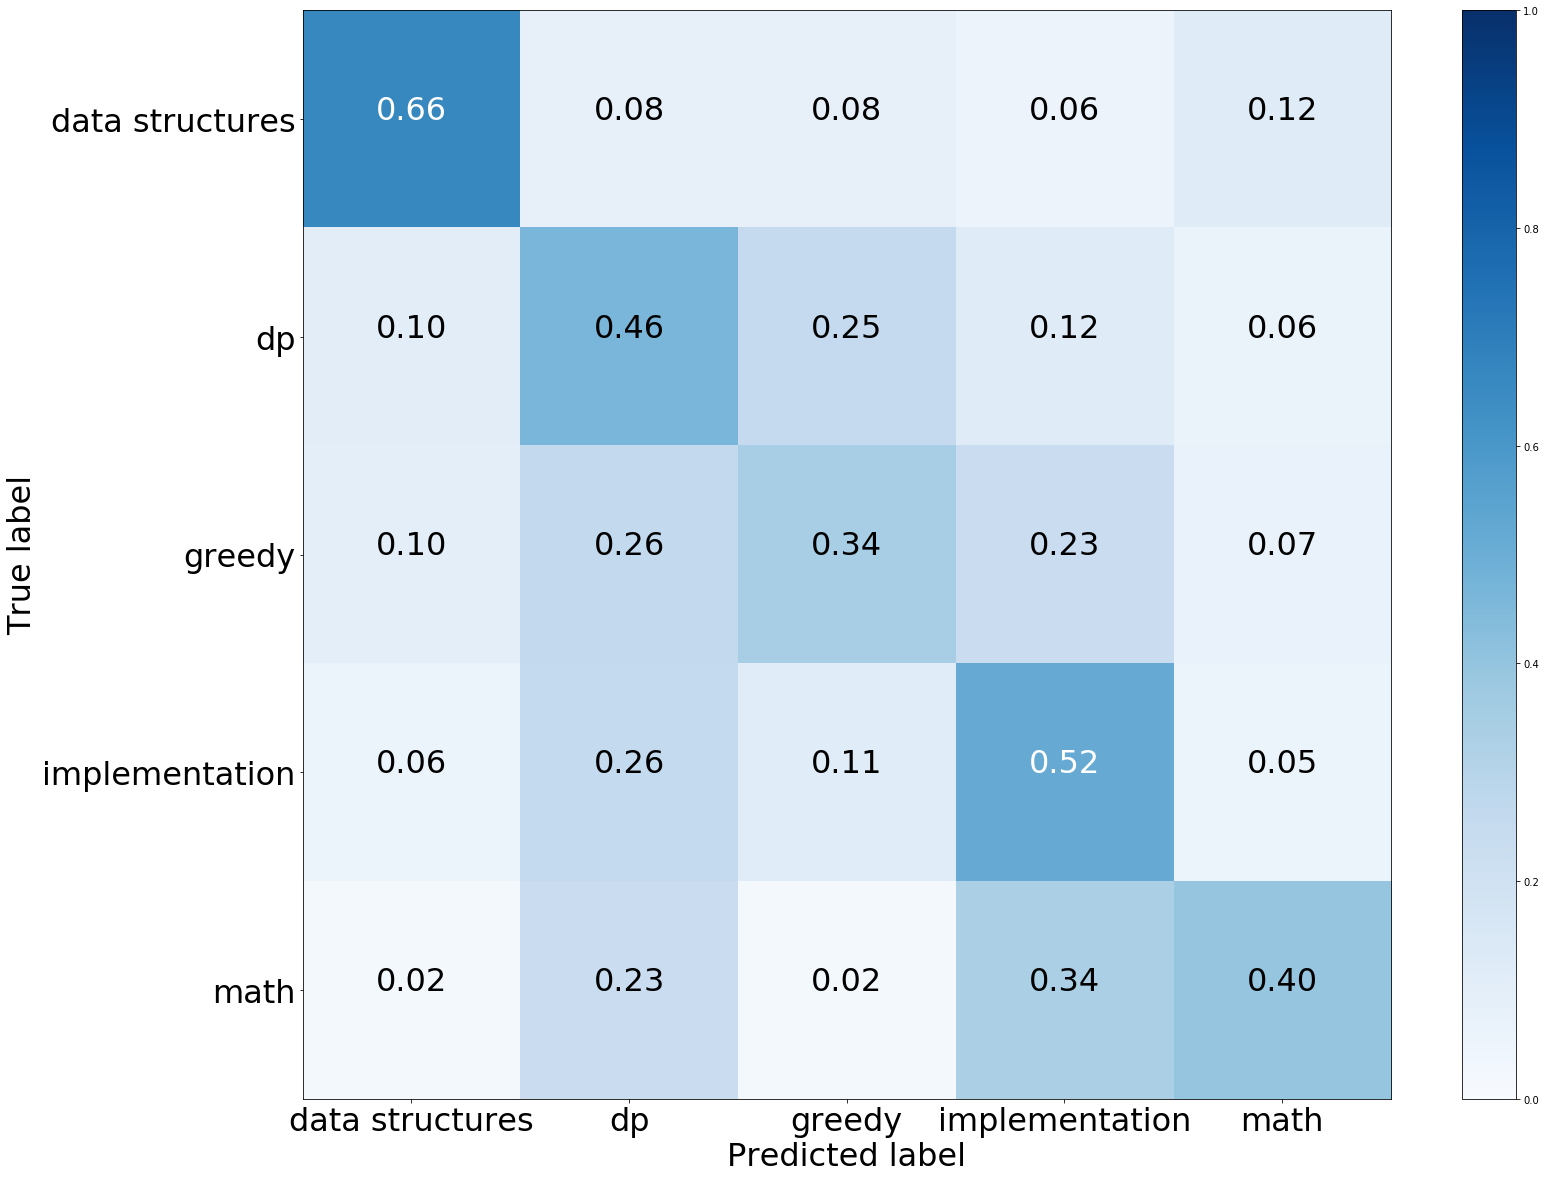

In [5]:
labels = ['data structures', 'dp', 'greedy', 'implementation', 'math']

print(classification_report(targs_txt, preds_txt, labels=labels, digits=5))
print(accuracy_score(targs_txt, preds_txt))
print(f1_score(targs_txt, preds_txt, average='weighted'))
plot_confusion_matrix(targs_txt, preds_txt, labels)